We define a dict to uniform biding area names among datasets. We also define a list of columns that we want to keep from the operating data. We then pivot the operating data to have a wide format, and we merge the operating data with the spot prices. We then rename the columns better readability.

In [2]:
import pandas as pd
from pandarallel import pandarallel
# use all CPU cores for applies
pandarallel.initialize(progress_bar=True)

# Load operating data
operating_data_df = pd.read_parquet('operating_data.parquet.gzip')
# Pivot data to have a wide format
operating_data_wide = operating_data_df.pivot(index=['date', 'datatype', 'country', 'bidding_area'], columns='code',
                                              values='value')
# free up memory
del operating_data_df

# Reset index to have a flat dataframe
operating_data_wide = operating_data_wide.reset_index()
area_mapping = {
    'Bergen': 'NO5 Norway',
    'Kristiansand': 'NO2 Norway',
    'Kristiansund': 'NO3 Norway',
    'Oslo': 'NO1 Norway',
    'Tromso': 'NO4 Norway',
    'Trondheim': 'NO3 Norway',
    'Denmark_East': 'DK2 Denmark',
    'Denmark_West': 'DK1 Denmark',
    'Denmark West': 'DK1 Denmark',
    'Denmark East': 'DK2 Denmark',
    'DK1': 'DK1 Denmark',
    'DK2': 'DK2 Denmark',
    'SE1_Lulea': 'SE1 Sweden',
    'SE2_Sundsvall': 'SE2 Sweden',
    'SE3_Stockholm': 'SE3 Sweden',
    'SE4_Malmo': 'SE4 Sweden',
    'Sverige1': 'SE1 Sweden',
    'Sverige2': 'SE2 Sweden',
    'Sverige3': 'SE3 Sweden',
    'Sverige4': 'SE4 Sweden',
}

# Select only the columns we want to keep
area_values = ['date', 'country', 'bidding_area', 'DD', 'E', 'F', 'P', 'PE', 'RC', 'RN', 'RO', 'RP', 'RS', 'WE', 'WS']
area_operating = operating_data_wide[area_values]
del operating_data_wide
# Fix bidding area names
area_operating.bidding_area = area_operating.parallel_apply(lambda x: area_mapping.get(x.bidding_area, x.bidding_area),
                                                            axis=1).astype('category')
# Load spot prices and fix bidding area names
prices_df = pd.read_parquet('spot_prices.parquet.gzip')
prices_df.bidding_area = prices_df.apply(lambda x: area_mapping.get(x.bidding_area, x.bidding_area), axis=1).astype(
    'category')

# Merge spot prices with operating data
merged = prices_df.merge(area_operating, on=['date', 'country', 'bidding_area'], how='left')
del area_operating, prices_df

# Rename columns for better readability
merged = merged.rename(columns={
    "price_eur_mwh": "spot_price",
    "WS": "wind_settled",
    "WE": "wind_estimated",
    "F": "consumption_settled",
    "P": "production_settled",
    "U": "net_exchange",
    "E": "consumption_estimated",
    "PE": "production_estimated",
    "RN": "regulating_down",
    "RO": "regulating_up",
    "RC": "imbalance_consumption_price",
    "RP": "imbalance_production_purchase_price",
    "RS": "imbalance_production_sell_price",
    "DD": "dominating_regulation", })

# Clean up data from duplicates and missing values
merged = merged.groupby(['date', 'country', 'bidding_area']).max().reset_index()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


We then select the data for Stockholm and interpolate missing values. We also resample the data to be able to work with the data efficiently.

In [4]:

stockholm_df = merged[(merged.bidding_area == 'SE3 Sweden') & (merged.country == 'Sweden')]
stockholm_df = stockholm_df.resample('D', on='date').mean(numeric_only=True).reset_index()
stockholm_df = stockholm_df.interpolate(method='pad', axis=0).ffill().bfill()
stockholm_df

,date,spot_price,dominating_regulation,consumption_estimated,consumption_settled,production_settled,production_estimated,imbalance_consumption_price,regulating_down,regulating_up,imbalance_production_purchase_price,imbalance_production_sell_price,wind_estimated,wind_settled
0,2013-12-30,28.849167,-0.333333,10389.666992,10345.000000,11731.166992,11718.000000,235.898331,114.809998,139.583130,261.860840,232.453323,169.666672,799.37500
1,2013-12-31,28.639168,0.750000,9856.416992,10088.625000,11916.833008,11882.375000,279.431244,123.809792,160.498749,281.789154,252.452927,169.666672,799.37500
2,2014-01-01,28.454168,-0.083333,9746.333008,9963.583008,11232.000000,11205.166992,242.394165,112.697502,148.499161,262.384583,232.728333,169.666672,799.37500
3,2014-01-02,29.987083,-0.250000,10683.125000,10608.833008,11560.416992,11551.041992,235.132507,107.772705,147.689789,270.671234,230.795410,169.666672,799.37500
4,2014-01-03,29.254166,0.458333,10645.958008,10784.833008,11415.666992,11362.666992,265.442902,123.444580,165.199799,274.191254,250.969589,169.666672,799.37500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,2023-03-13,40.752918,0.133333,11461.708008,11493.133789,9180.933594,9394.750000,129.631607,330.886658,442.940643,384.303589,123.029602,752.875000,998.93335
3361,2023-03-14,56.917919,0.133333,11461.708008,11493.133789,9180.933594,9394.750000,129.631607,330.886658,442.940643,384.303589,123.029602,752.875000,998.93335
3362,2023-03-15,86.086250,0.133333,11461.708008,11493.133789,9180.933594,9394.750000,129.631607,330.886658,442.940643,384.303589,123.029602,752.875000,998.93335
3363,2023-03-16,81.559998,0.133333,11461.708008,11493.133789,9180.933594,9394.750000,129.631607,330.886658,442.940643,384.303589,123.029602,752.875000,998.93335


Feature engeeniring. We add the hour of the day, if it is daylight, the day of the week and if it is a weekday. We then sort the data by date.

In [6]:
import numpy as np

stockholm_df['hours'] = stockholm_df.date.dt.hour
stockholm_df['daylight'] = ((stockholm_df['hours'] >= 7) & (stockholm_df['hours'] <= 22)).astype('int8')
stockholm_df['DayOfTheWeek'] = stockholm_df.date.dt.dayofweek
stockholm_df['WeekDay'] = (stockholm_df['DayOfTheWeek'] < 5).astype('int8')
stockholm_df['categories'] = stockholm_df['WeekDay'] * 2 + stockholm_df['daylight']
stockholm_df = stockholm_df.sort_values(by='date')

We then select the data we want to use for training and standardize it.

In [7]:
from sklearn import preprocessing

#select and standardize data
data_n = stockholm_df.drop(columns=['date'])
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

We then create the sequence data for the LSTM model. We use the last 50 days of data to predict the next week.

In [8]:
# important parameters and train/test size
prediction_time = 7
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length + 1

#train data
x_train = data_n[0:-prediction_time - testdatacut].values
y_train = data_n[prediction_time:-testdatacut][0].values

# test data
x_test = data_n[0 - testdatacut:-prediction_time].values
y_test = data_n[prediction_time - testdatacut:][0].values


#unroll: create sequence of 50 previous data points for each data points
def unroll(data, sequence_length=2160):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


# adapt the datasets for the sequence data shape
x_train = unroll(x_train, unroll_length)
x_test = unroll(x_test, unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test = y_test[-x_test.shape[0]:]

We then build the LSTM model and train it.

In [9]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import time
import tensorflow as tf

# Build the model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    units=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam())
print('compilation time : {}'.format(time.time() - start))
# Train the model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=30,
    validation_split=0.1)

Metal device set to: Apple M1 Max


2023-03-27 13:42:29.385176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 13:42:29.385203: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


compilation time : 0.0353846549987793
Epoch 1/30


2023-03-27 13:42:30.022749: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-27 13:42:30.787711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-27 13:42:30.926250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-27 13:42:31.368357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-27 13:42:32.109376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-27 13:42:32.948264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step - loss: 0.1365 - val_loss: 0.1763
Epoch 2/30


2023-03-27 13:42:33.453651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-27 13:42:33.505547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-27 13:42:33.552238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 208ms/step - loss: 0.0789 - val_loss: 0.1288
Epoch 3/30
1/1 [==============================] - 0s 193ms/step - loss: 0.0456 - val_loss: 0.0863
Epoch 4/30
1/1 [==============================] - 0s 194ms/step - loss: 0.0313 - val_loss: 0.0531
Epoch 5/30
1/1 [==============================] - 0s 195ms/step - loss: 0.0324 - val_loss: 0.0355
Epoch 6/30
1/1 [==============================] - 0s 201ms/step - loss: 0.0389 - val_loss: 0.0297
Epoch 7/30
1/1 [==============================] - 0s 194ms/step - loss: 0.0386 - val_loss: 0.0302
Epoch 8/30
1/1 [==============================] - 0s 199ms/step - loss: 0.0313 - val_loss: 0.0329
Epoch 9/30
1/1 [==============================] - 0s 195ms/step - loss: 0.0265 - val_loss: 0.0359
Epoch 10/30
1/1 [==============================] - 0s 193ms/step - loss: 0.0252 - val_loss: 0.0383
Epoch 11/30
1/1 [==============================] - 0s 216ms/step - loss: 0.0251 - val_loss: 0.0396
Epoch 12/30
1/1 [============

We then evaluate the model. First we plot the prediction and the reality for the test period. Then we use the complete dataset and take 5% of outliers as anomalies.

32/32 [==============================] - 0s 7ms/step


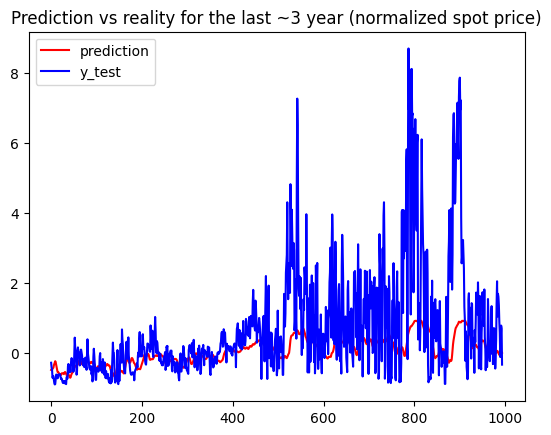

0.0    3310
1.0      49
Name: anomaly27, dtype: int64


/var/folders/l_/yszbrvm96clcdwdldb5h3gmr0000gn/T/ipykernel_27106/4277316208.py:29: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stockholm_df['anomaly27'] = complement.append(test, ignore_index='True')


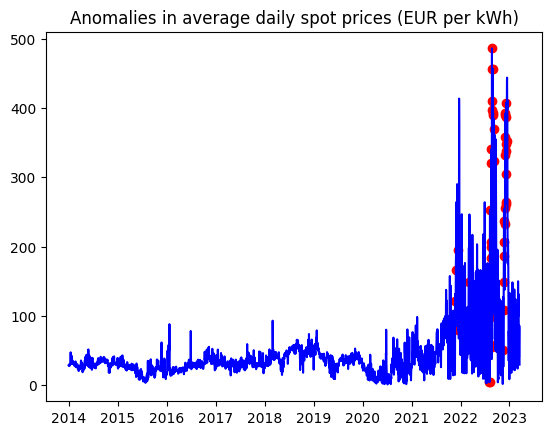

In [17]:
# create the list of difference between prediction and test data
loaded_model = model
diff = []
ratio = []
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))
import matplotlib.pyplot as plt

# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p, color='red', label='prediction')
axs.plot(y_test, color='blue', label='y_test')
axs.set_title('Prediction vs reality for the last ~3 year (normalized spot price)')
plt.legend(loc='upper left')
plt.show()
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(0.05 * len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n) - testdatasize))
# # add the data to the main
stockholm_df['anomaly27'] = complement.append(test, ignore_index='True')
print(stockholm_df['anomaly27'].value_counts())
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = stockholm_df.loc[stockholm_df['anomaly27'] == 1, ['date', 'spot_price']]  #anomaly

ax.plot(stockholm_df['date'], stockholm_df['spot_price'], color='blue')
ax.set_title('Anomalies in average daily spot prices (EUR per kWh)')
ax.scatter(a['date'], a['spot_price'], color='red')
# plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()